In [1]:
# This script will do CNN operations on sequence data (thus its in 1 dimension instead of 2 so we use Conv1D layers)
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [2]:
# Data preparation similar to spam detection RNN
!wget https://lazyprogrammer.me/course_files/spam.csv

--2022-07-26 03:04:58--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.006s  

2022-07-26 03:04:58 (75.5 MB/s) - ‘spam.csv’ saved [503663/503663]



In [3]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.columns = ['labels', 'data']
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [4]:
Y = df['b_labels'].values
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [5]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [6]:
word2idx = tokenizer.word_index
V = len(word2idx)

In [7]:
data_train = pad_sequences(sequences_train)
T = data_train.shape[1]

In [8]:
data_test = pad_sequences(sequences_test, maxlen=T)

In [9]:
# Build model
D = 20
i = Input(shape=(T,))
# Embedding makes the sequence data for text suitable to be used with CNN structure
x = Embedding(V + 1, D)(i) # output is T x D
# Number of feature maps doubles with each convolution, as series length decreases
x = Conv1D(32, 3, activation='relu')(x) # output is T* x M
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x) # output is T2 x M2
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x) # output is T3 x M3
x = GlobalMaxPooling1D()(x) # output is M3
x = Dense(1, activation='sigmoid')(x) # output is 1

model = Model(i, x)

In [10]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

r = model.fit(
    data_train,
    Ytrain,
    epochs=5,
    validation_data=(data_test, Ytest)
)

Epoch 1/5
117/117 [==============================] - 14s 10ms/step - loss: 0.4055 - accuracy: 0.8685 - val_loss: 0.3662 - val_accuracy: 0.8608
Epoch 2/5
117/117 [==============================] - 1s 6ms/step - loss: 0.2274 - accuracy: 0.9030 - val_loss: 0.1190 - val_accuracy: 0.9695
Epoch 3/5
117/117 [==============================] - 1s 6ms/step - loss: 0.0344 - accuracy: 0.9909 - val_loss: 0.1334 - val_accuracy: 0.9750
Epoch 4/5
117/117 [==============================] - 1s 10ms/step - loss: 0.0162 - accuracy: 0.9944 - val_loss: 0.1555 - val_accuracy: 0.9744
Epoch 5/5
117/117 [==============================] - 1s 8ms/step - loss: 0.0089 - accuracy: 0.9976 - val_loss: 0.1551 - val_accuracy: 0.9755


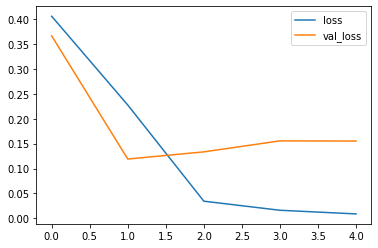

In [11]:
# very nice results, comparable to RNN
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

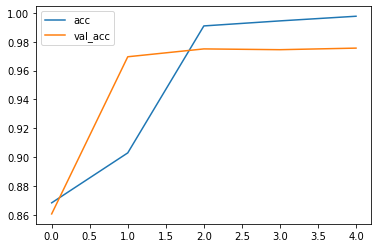

In [12]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()